In [19]:
import pyspark as ps
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

In [2]:
import pyspark as ps
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import logging
import pandas as pd
import numpy as np


class RecipeRecommender():
    """
    Recommendation engine class - uses MLLib Alternating Least Squares Model
    """

    def __init__(self, rank=10, reg=0.5):
        """ Initializes Spark and ALS model selection """
        spark = (
            ps.sql.SparkSession.builder
            .master('local[4]')
            .appName('BVS')
            .getOrCreate()
        )
        self.spark = spark
        self.sc = self.spark.sparkContext

        self.model = ALS(
            maxIter=5,
            rank=rank,
            itemCol='recipe_id',
            userCol='user_id',
            ratingCol='rating',
            nonnegative=True,
            regParam=reg,
#             coldStartStrategy="drop"
            )


    def fit(self, ratings):
        """
        Trains the recommender on a given set of ratings.

        Parameters
        ----------
        ratings : pandas dataframe, shape = (n_ratings, 4)
                  with columns 'user', 'recipe', 'rating'

        Returns
        -------
        self : object
            Returns self.
        """
        """ Convert a Pandas DF to a Spark DF """
        ratings_df = self.spark.createDataFrame(ratings)
        """
        Train the ALS model. We'll call the trained model `recommender`.
        """
        self.recommender_ = self.model.fit(ratings_df)
        return self


    def transform(self, requests):
        """
        Predicts the ratings for a given set of user_id/recipe_id pairs.

        Parameters
        ----------
        requests : pandas dataframe, shape = (n_ratings, 2)
                  with columns 'user', 'movie'

        Returns
        -------
        dataframe : a pandas dataframe with columns 'user', 'movie', 'rating'
                    column 'rating' containing the predicted rating
        """
        # Convert a Pandas DF to a Spark DF
        requests_df = self.spark.createDataFrame(requests)
        self.predictions = self.recommender_.transform(requests_df)
        return self.predictions.toPandas()


    def evaluate(self, requests, pred_col='prediction'):
        requests_df = self.spark.createDataFrame(requests)
        evaluator = RegressionEvaluator(
                metricName="rmse",
                labelCol="rating",
                predictionCol=pred_col
            )
        rmse = evaluator.evaluate(requests_df)
        return rmse

    def recommend_for_all(self, who='users', number=10):
        if who == 'users':
            user_recs = self.recommender_.recommendForAllUsers(number)
            return (user_recs.toPandas())
        else:
            recipe_recs = self.recommender_.recommendForAllItems(number)
            return (recipe_recs.toPandas)

    def model_save(self, filepath):
        self.recommender_.save(self.sc, filepath)


if __name__ == "__main__":
    pass


In [3]:
df = pd.read_csv('data/f52_user_item_rating3.csv')

In [5]:
del df['Unnamed: 0']
del df['rating.1']
df.head(100)

,user_id,recipe_id,rating
0,3604,1283,2
1,1772,1283,2
2,15674,1283,0
3,5953,1283,2
4,5290,1283,3
5,1643,1283,3
6,5290,1283,3
7,3558,1283,1
8,1224,4194,0
9,10253,4194,3


In [6]:
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
y = df['rating'].values
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
train_df = pd.DataFrame(X_train)
test_df = pd.DataFrame(X_test)
cols = 'user_id recipe_id rating'.split()
train_df.columns = cols
test_df.columns = cols
test_df_preds = test_df[['user_id', 'recipe_id']]

In [8]:
train_df_preds = train_df[['user_id', 'recipe_id']]

In [9]:
def rmse(preds, train_df, test_df):
    train_rating_mean = train_df['rating'].mean()
    new_df = preds.merge(test_df, how='left', on=['user_id', 'recipe_id'])
    new_df['user_bias'] = new_df['user_id'].apply(user_bias)
    new_df['recipe_bias'] = new_df['recipe_id'].apply(recipe_bias)
    new_df['total_bias'] = new_df['recipe_bias'] + new_df['user_bias']
    new_df['adjusted'] = new_df['prediction'] + new_df['total_bias'] + 1.4
    new_df['adjusted'].fillna(new_df['total_bias'].apply(lambda x: train_rating_mean + x ), inplace=True)
    y_pred = new_df['adjusted']
    y_true = new_df['rating']
    return np.sqrt(mean_squared_error(y_true, y_pred)), new_df

def user_bias(col):
    user_groups = train_df['rating'].mean() - train_df.groupby('user_id')['rating'].mean()
    if col in user_groups.index:
        return user_groups[col]
    else:
        return 0

def recipe_bias(col):
    recipe_groups = train_df['rating'].mean() - train_df.groupby('recipe_id')['rating'].mean()
    if col in recipe_groups:
        return recipe_groups[col]
    else:
        return 0

In [10]:
rec_f52 = RecipeRecommender()

In [11]:
rec_f52.fit(train_df)

<__main__.RecipeRecommender instance at 0x111f96680>

In [12]:
preds = rec_f52.transform(test_df_preds)
# train_preds = rec_f52.transform(train_df_preds)

In [13]:
mse_score, new_df = rmse(preds, train_df, test_df)
# rmse_train = rmse(train_preds, train_df, train_df)

In [14]:
mse_score
# rmse_train

1.8523221302353454

In [42]:
def optimization(train_df, test_df_preds, test_df):
    output = []
    params = {'rank':[1, 2, 5, 10, 50], 'reg':[0.1, 0.5, 1]}
    combi = list(ParameterGrid(params))
    for dct in combi:
        rank, reg = dct['rank'], dct['reg']
        model = RecipeRecommender(rank, reg)
        model.fit(train_df)
        preds = model.transform(test_df_preds)
        rmse_score = rmse(preds, train_df, test_df)
        output.append([rank, reg, rmse_score])
    return output

In [43]:
opt_list = optimization(train_df, test_df_preds, test_df)

In [44]:
opt_list

[[1, 0.1, 1.9255140550705754],
 [1, 0.5, 1.8443289084717196],
 [1, 1, 1.8429735762599671],
 [2, 0.1, 1.9358805733696742],
 [2, 0.5, 1.8422024647629296],
 [2, 1, 1.8436111949337892],
 [5, 0.1, 1.9303516828828169],
 [5, 0.5, 1.8422543798348814],
 [5, 1, 1.8467042564432177],
 [10, 0.1, 1.916442227203446],
 [10, 0.5, 1.8407372224643237],
 [10, 1, 1.8475948445036885],
 [50, 0.1, 1.8984452191443517],
 [50, 0.5, 1.8402823928352565],
 [50, 1, 1.8486015350188407]]

In [45]:
df_opt = pd.DataFrame.from_records(opt_list)

In [46]:
df_opt.columns = 'rank reg rmse'.split()

In [47]:
df_opt['rmse'].min()

1.8402823928352565

In [58]:
df_opt

,rank,reg,rmse,rank_reg
0,1,0.1,1.925514,"(1, 0.1)"
1,1,0.5,1.844329,"(1, 0.5)"
2,1,1.0,1.842974,"(1, 1.0)"
3,2,0.1,1.935881,"(2, 0.1)"
4,2,0.5,1.842202,"(2, 0.5)"
5,2,1.0,1.843611,"(2, 1.0)"
6,5,0.1,1.930352,"(5, 0.1)"
7,5,0.5,1.842254,"(5, 0.5)"
8,5,1.0,1.846704,"(5, 1.0)"
9,10,0.1,1.916442,"(10, 0.1)"


In [50]:
import seaborn as sns

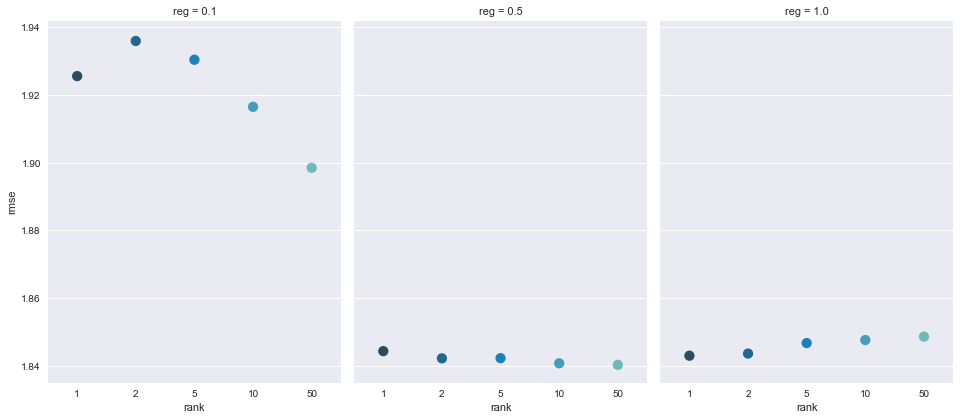

In [66]:
import matplotlib.pyplot as plt
g = sns.factorplot(x="rank", y="rmse", col="reg", data=df_opt,
                   capsize=.2, palette="YlGnBu_d", size=6, aspect=.75)
g.despine(left=True)

In [68]:
# sns.set(style="whitegrid")

# g = sns.PairGrid(df_opt, y_vars="rmse",
#                  x_vars=["rank", "reg"],
#                  size=5, aspect=.5)

# g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
# # g.set(ylim=(0, 1))
# sns.despine(fig=g.fig, left=True)

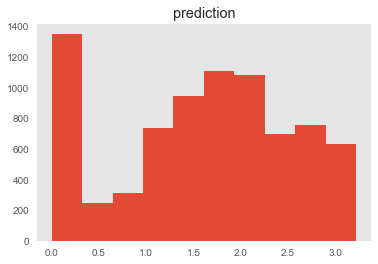

In [70]:
%matplotlib inline
plt.style.use('ggplot')
preds.hist('prediction')
plt.grid(False)

In [91]:
preds

,user_id,recipe_id,prediction
0,8307,148,NaN
1,0,463,NaN
2,11082,471,2.133166
3,13048,496,2.083966
4,1386,496,2.142402
5,16567,496,2.143824
6,2919,496,2.022722
7,5778,1088,1.086790
8,8014,1088,0.921228
9,15477,1088,1.061062


In [95]:
new_df.head()

,user_id,recipe_id,prediction,rating,user_bias,recipe_bias,total_bias,adjusted
0,8307,148,NaN,0,0.000000,-1.060888,-1.060888,0.878223
1,0,463,NaN,0,1.939112,0.000000,1.939112,3.878223
2,11082,471,2.133166,3,-1.060888,0.081969,-0.978920,2.554247
3,13048,496,2.083966,3,-0.861936,0.139112,-0.722824,2.761142
4,1386,496,2.142402,3,-1.060888,0.139112,-0.921777,2.620626


In [30]:
y = new_df['rating'].values
y2 = new_df['adjusted'].values

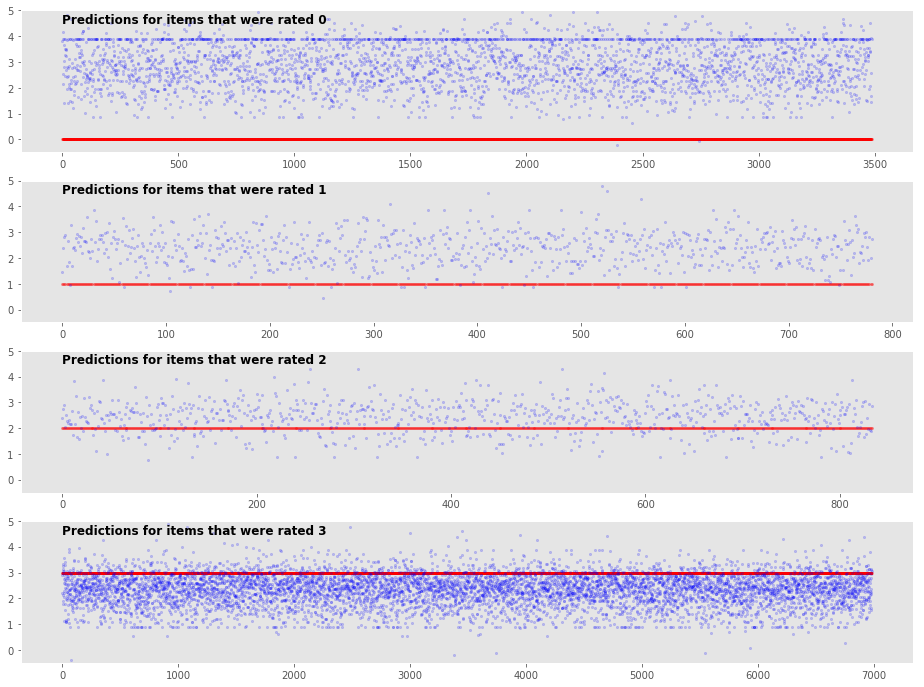

In [55]:
x = np.arange(len(y))
np.random.shuffle(x)
fig, axs = plt.subplots(4, 1, figsize=(16, 12))
# ax.scatter(x, y, c='r', s=5, alpha=0.4)
# ax.scatter(x, y2, c='b', s=6, alpha=0.3)
for n in range(4):
    y_true = y[np.where(y==n)]
    y_pred = y2[np.where(y==n)]
    x = np.arange(len(y_true))
    np.random.shuffle(x)
    axs[n].scatter(x, y_true, c='r', s=5, alpha=0.4)
    axs[n].scatter(x, y_pred, c='b', s=6, alpha=0.2)
    axs[n].set_ylim([-0.5, 5])
    text_insert = 'Predictions for items that were rated {}'.format(str(n))
    axs[n].text(0, 4.5, text_insert, fontsize=12, color='k', fontweight='bold')
    axs[n].grid(False)


In [32]:
y_true = y[np.where(y==n)]

In [34]:
y_pred = y2[np.where(y==n)]

In [35]:
y_pred

array([ 0.87822318,  3.87822318,  3.66946193, ...,  2.9220501 ,
        2.3909326 ,  2.3909326 ])